In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [8, 6]

In [2]:
from darwinian_shift import DarwinianShift
from darwinian_shift import CDFMonteCarloTest
from darwinian_shift.lookup_classes.foldx_lookup import FoldXLookupError
from darwinian_shift import hide_top_and_right_axes

/Users/mh28/miniconda3/envs/dsenv3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mh28/miniconda3/envs/dsenv3/lib/python3.8/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


In [3]:
from scipy.stats import pearsonr

In [4]:
import seaborn as sns

In [5]:
# This file can be downloaded from Colom et al 2020 https://www.nature.com/articles/s41588-020-0624-3
muts = pd.read_excel("41588_2020_624_MOESM3_ESM.xlsx", 
                    sheet_name='Supplementary Table 2', skiprows=23)

In [6]:
# Select the mutagen treated mice
muts_DEN = muts[muts['mouse'].isin(['MD5695', 'MD5694', 'MD5693'])]

In [7]:
import os


class FoldXLookup2:
    """
    Class to read the FoldX results from CSV files.  
    There must be one CSV per protein.  
    The CSV file must contain the following columns
     - 'mut_from' and 'mut_to' containing the three-letter amino acid codes
     - 'gene_no' containing the residue number
     - 'ddg' containing the ∆∆G result for that amino acid change. 
    Each file can contain results from multiple structures, if there is more than one structure covering 
    the same residue, the average ∆∆G for that mutation will be returned. 
    """
    
    # Map of 3-letter codes to 1-letter code from http://foldxsuite.crg.eu/allowed-residues
    AA_map = {'GLY': 'G', 'ALA': 'A', 'LEU': 'L', 'VAL': 'V', 'ILE': 'I', 'PRO': 'P', 'ARG': 'R',
              'THR': 'T', 'SER': 'S', 'CYS': 'C', 'MET': 'M', 'LYS': 'K', 'GLU': 'E', 'GLN': 'Q',
              'ASP': 'D', 'ASN': 'N', 'TRP': 'W', 'TYR': 'Y', 'PHE': 'F', 'HIS': 'H',
              'PTR': 'T',  # phoshoporylated threonine
              'TPO': 'Y',  # phosphorylated tyrosine
              'SEP': 'S',  # phosphorylated serine
              'HYP': 'P',  # hydroxiproline
              'TYS': 'Y',  # sulfotyrosine
              'MLZ': 'K',  # monomethylated lysine
              'MLY': 'K',  # dimethylated lysine
              'M3L': 'K',  # trimethylated lysine
              'H1S': 'H',  # charged ND1 histidine
              'H2S': 'H',  # charged NE2 histidine
              'H3S': 'H'  # neutral histidine
             }
    
    def __init__(self, foldx_results_dir):
        self.foldx_results_dir = foldx_results_dir
        
    def __call__(self, seq_object):
        return self._get_scores(seq_object)
        
    def get_foldx_results(self, seq_object):
        try: 
            foldx_results = pd.read_csv(os.path.join(self.foldx_results_dir, f"mouse_{seq_object.gene}.csv"))
        except FileNotFoundError as e:
            raise FoldXLookupError('FoldX: Found no results for {}'.format(self.foldx_results_dir))
        # convert to format that can be merged
        foldx_results['aamut'] = foldx_results['mut_to'].apply(lambda x: self.AA_map[x])
        foldx_results['aaref'] = foldx_results['mut_from'].apply(lambda x: self.AA_map[x])
        # Keep the reference amino acid to ensure that any reference mismatches are not merged
        foldx_results = foldx_results.groupby(['gene_no', 'aaref', 'aamut']).agg('mean').reset_index()
        return foldx_results
    
    def _get_scores(self, seq_object):
        foldx_results = self.get_foldx_results(seq_object)
        merge_df = pd.merge(seq_object.null_mutations, foldx_results, left_on=['residue', 'aaref', 'aamut'], 
                    right_on=['gene_no', 'aaref', 'aamut'], how='left')
        scores = merge_df['ddg'].values
        return scores
    
    

In [8]:
# Set the path to the directory containing all of the mouse structure ∆∆G results
f = FoldXLookup2("./MouseResults/")

# Correlation results

In [9]:
# This is a different sheet from the same file containing the mutations. 
dnds = pd.read_excel("41588_2020_624_MOESM3_ESM.xlsx", 
                    sheet_name='Supplementary Table 3', skiprows=27)[:190]

In [10]:
# Run quickly to get a gene list
d = DarwinianShift(muts_DEN, source_genome='mus_musculus', 
                  lookup=f)
# save the spectrum
d.spectra[0].write_to_file("mouse_DEN_glob_k3.txt")

In [11]:
# Only look at the genes in both the Ensembl transcripts and the dN/dS results
genes =set(d.get_gene_list()).intersection(dnds['gene_name'])

In [12]:
d = DarwinianShift(muts_DEN, source_genome='mus_musculus', 
                   spectra="mouse_DEN_glob_k3.txt", 
                  lookup=f, gene_list=genes, statistics=CDFMonteCarloTest(num_draws=100000))

In [13]:
d.run_all(verbose=True)

Running ENSMUST00000140079 St18
Running ENSMUST00000166384 Sgk3
Running ENSMUST00000027056 Prex2
Running ENSMUST00000088448 Pkhd1
FoldXLookupError FoldX: Found no results for /Users/mh28/Documents/Darwinian_shift_paper/2021/MouseResults/ - Unable to run for ENSMUST00000088448
Running ENSMUST00000183034 Dst


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000238906 Aff3
Running ENSMUST00000191201 Casp8
Running ENSMUST00000119142 Erbb4
Running ENSMUST00000055226 Fn1


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000163119 Cul3
Running ENSMUST00000186485 Pign
Running ENSMUST00000131855 Eif2d
Running ENSMUST00000047714 Kdm5b
Running ENSMUST00000074783 Hmcn1
FoldXLookupError FoldX: Found no results for /Users/mh28/Documents/Darwinian_shift_paper/2021/MouseResults/ - Unable to run for ENSMUST00000074783
Running ENSMUST00000192069 Tnr


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000027852 Adcy10
Running ENSMUST00000194690 Ddr2
Running ENSMUST00000027809 Opn3
Running ENSMUST00000076521 Irf6
Running ENSMUST00000210219 Cr2
FoldXLookupError FoldX: Found no results for /Users/mh28/Documents/Darwinian_shift_paper/2021/MouseResults/ - Unable to run for ENSMUST00000210219
Running ENSMUST00000020045 Ros1
Running ENSMUST00000219238 Arid5b
Running ENSMUST00000164107 Bcr
Running ENSMUST00000020547 Vmn2r81


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000049149 Lrp1
Running ENSMUST00000082059 Erbb3
Running ENSMUST00000109910 Nf2
Running ENSMUST00000020329 Egfr
Running ENSMUST00000041231 Psme4
Running ENSMUST00000059458 Maml1
Running ENSMUST00000102703 Zfp39


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000108658 Trp53
Running ENSMUST00000071325 Nf1
Running ENSMUST00000108061 Bcas3
Running ENSMUST00000058295 Erbb2
Running ENSMUST00000105059 Krtap4-9
Running ENSMUST00000103029 Rhbdf2
Running ENSMUST00000092298 Zfp750
Running ENSMUST00000020991 Dnmt3a
Running ENSMUST00000037811 Apob
FoldXLookupError FoldX: Found no results for /Users/mh28/Documents/Darwinian_shift_paper/2021/MouseResults/ - Unable to run for ENSMUST00000037811
Running ENSMUST00000042299 Kcnh5
Running ENSMUST00000041987 Dicer1
FoldXLookupError FoldX: Found no results for /Users/mh28/Documents/Darwinian_shift_paper/2021/MouseResults/ - Unable to run for ENSMUST00000041987
Running ENSMUST00000066060 Bcl11b
Running ENSMUST00000001780 Akt1
Running ENSMUST00000021750 Ryr2


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000099490 Nsd1
Running ENSMUST00000021921 Ptch1


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000049705 Zfp457


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000109552 Rasa1
Running ENSMUST00000112249 Cacna1d


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000111603 Rpgrip1
Running ENSMUST00000054487 Ajuba
Running ENSMUST00000022701 Rb1
Running ENSMUST00000048646 Vps13b
FoldXLookupError FoldX: Found no results for /Users/mh28/Documents/Darwinian_shift_paper/2021/MouseResults/ - Unable to run for ENSMUST00000048646
Running ENSMUST00000041733 Taf2
FoldXLookupError FoldX: Found no results for /Users/mh28/Documents/Darwinian_shift_paper/2021/MouseResults/ - Unable to run for ENSMUST00000041733
Running ENSMUST00000068387 Ep300
Running ENSMUST00000096250 Arid2
Running ENSMUST00000059433 Pced1b
Running ENSMUST00000023741 Kmt2d
Running ENSMUST00000023709 Krt5
Running ENSMUST00000023806 Soat2
Running ENSMUST00000023165 Crebbp
Running ENSMUST00000199708 Grin2a


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000115310 Trp63
Running ENSMUST00000019386 Ripk4


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000087723 Notch3


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000015612 Notch4


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000024882 Ttc27
Running ENSMUST00000025288 Zfp521
Running ENSMUST00000025497 Fbn2
Running ENSMUST00000025393 Smad4
Running ENSMUST00000148341 Loxhd1
Running ENSMUST00000013807 Pten
Running ENSMUST00000226068 Myof
Running ENSMUST00000026208 Abcc2


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000026217 Chuk


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000111867 Sufu
Running ENSMUST00000182276 Dclre1a
Running ENSMUST00000028288 Notch1


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000113889 Gtf3c5
Running ENSMUST00000113869 Tsc1
Running ENSMUST00000061578 Setx


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000065398 Nup214
Running ENSMUST00000052550 Lrp1b
Running ENSMUST00000112431 Cobll1
FoldXLookupError FoldX: Found no results for /Users/mh28/Documents/Darwinian_shift_paper/2021/MouseResults/ - Unable to run for ENSMUST00000112431
Running ENSMUST00000100069 Scn3a


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000112366 Scn1a


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000102710 Abcb11


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000080953 Lrp2
Running ENSMUST00000102672 Nfe2l2
Running ENSMUST00000102476 B2m
Running ENSMUST00000110116 Plcb1
Running ENSMUST00000109790 Asxl1
Running ENSMUST00000109441 Ptprt
Running ENSMUST00000028997 Aurka
FoldXLookupError FoldX: Found no results for /Users/mh28/Documents/Darwinian_shift_paper/2021/MouseResults/ - Unable to run for ENSMUST00000028997
Running ENSMUST00000108243 Pik3ca


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000099151 Sox2
Running ENSMUST00000061260 Fat4
Running ENSMUST00000054237 Dclk1
Running ENSMUST00000167334 Sis
FoldXLookupError FoldX: Found no results for /Users/mh28/Documents/Darwinian_shift_paper/2021/MouseResults/ - Unable to run for ENSMUST00000167334
Running ENSMUST00000048647 Rbm46
Running ENSMUST00000107679 Fbxw7
Running ENSMUST00000029711 Insrr


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000098884 Flg2
Running ENSMUST00000090750 Pde4dip


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000079812 Notch2


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000029445 Nras
Running ENSMUST00000196398 Tet2
Running ENSMUST00000029812 Nfkb1


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000037035 Ripk2
Running ENSMUST00000107131 Cdkn2a
Running ENSMUST00000165709 Usp24


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000145664 Arid1a
Running ENSMUST00000006614 Epha2
Running ENSMUST00000105786 Spen
Running ENSMUST00000103221 Mtor


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000044492 Akap9
FoldXLookupError FoldX: Found no results for /Users/mh28/Documents/Darwinian_shift_paper/2021/MouseResults/ - Unable to run for ENSMUST00000044492
Running ENSMUST00000004076 Grm3
Running ENSMUST00000045291 Kmt2c
Running ENSMUST00000114411 Fgfr3
Running ENSMUST00000005815 Kit
Running ENSMUST00000113516 Kdr
Running ENSMUST00000112696 Zfp644
FoldXLookupError FoldX: Found no results for /Users/mh28/Documents/Darwinian_shift_paper/2021/MouseResults/ - Unable to run for ENSMUST00000112696
Running ENSMUST00000202447 Fbxo21
Running ENSMUST00000179939 Atp2a2
Running ENSMUST00000117564 Zan
Running ENSMUST00000000505 Mcm7


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000085786 Card11
Running ENSMUST00000100489 Rac1
Running ENSMUST00000213013 Trrap


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000049324 Flt3
Running ENSMUST00000202313 Brca2


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000166678 Peg10
Running ENSMUST00000115443 Met
Running ENSMUST00000031713 Slc13a1
Running ENSMUST00000001812 Smo
Running ENSMUST00000002487 Braf
Running ENSMUST00000081721 Ezh2
Running ENSMUST00000035673 Vhl
Running ENSMUST00000088644 Wnk1
Running ENSMUST00000071149 Klrc3
Running ENSMUST00000069268 Tas2r102
Running ENSMUST00000111710 Kras
Running ENSMUST00000108653 Nlrp12


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000005669 Cyp2b13
Running ENSMUST00000108344 Akt2
Running ENSMUST00000094388 Mrgprb4
Running ENSMUST00000074233 Synm
Running ENSMUST00000167377 Iqgap1
Running ENSMUST00000122054 Fgfr2
FoldXLookupError FoldX: Found no results for /Users/mh28/Documents/Darwinian_shift_paper/2021/MouseResults/ - Unable to run for ENSMUST00000122054
Running ENSMUST00000026572 Hras
Running ENSMUST00000093962 Ccnd1
Running ENSMUST00000043962 Cdc16
Running ENSMUST00000179592 Fgfr1
Running ENSMUST00000215588 Fat1
Running ENSMUST00000110378 Snx25
Running ENSMUST00000053441 Adam29
Running ENSMUST00000002259 Clgn
Running ENSMUST00000209532 Cyld
Running ENSMUST00000034090 Sall1
Running ENSMUST00000098473 Cnot1


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000005841 Ctcf
Running ENSMUST00000000312 Cdh1


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000220518 Zfhx3
Running ENSMUST00000043141 Hydin
Running ENSMUST00000118171 Cntnap4


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000160272 Pard3


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000194542 Keap1
Running ENSMUST00000072362 Dnm2


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000098948 Smarca4
Running ENSMUST00000147405 Bbs9
Running ENSMUST00000232179 Atm
Running ENSMUST00000118163 Dmxl2
FoldXLookupError FoldX: Found no results for /Users/mh28/Documents/Darwinian_shift_paper/2021/MouseResults/ - Unable to run for ENSMUST00000118163
Running ENSMUST00000067880 Adam10
Running ENSMUST00000071750 Col12a1
Running ENSMUST00000035033 Copb2


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000153838 Setd2
Running ENSMUST00000035077 Ltf
Running ENSMUST00000214408 Scn10a


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000215718 Scn11a


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000089302 Usp9x


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000052368 Kdm6a
Running ENSMUST00000033442 Igsf1


/var/folders/fz/0b7ldhcd0rb8rnh3wct1_92c000gly/T/ipykernel_40291/4174190489.py:42: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  foldx_results = self.get_foldx_results(seq_object)


Running ENSMUST00000114869 Usp26
Running ENSMUST00000008826 Rpl10
FoldXLookupError FoldX: Found no results for /Users/mh28/Documents/Darwinian_shift_paper/2021/MouseResults/ - Unable to run for ENSMUST00000008826
Running ENSMUST00000113573 Atrx
Running ENSMUST00000026292 Huwe1


In [14]:
mer = pd.merge(d.results, dnds, left_on='gene', right_on='gene_name')

In [15]:
mer['shift'] = mer['CDF_MC_glob_k3_cdf_mean'] - 0.5

In [16]:
mer['wnon_cv'] = mer['wnon_cv'].astype(float)

In [17]:
mer50 = mer[mer['num_mutations'] >= 50]

In [18]:
len(mer50)

84

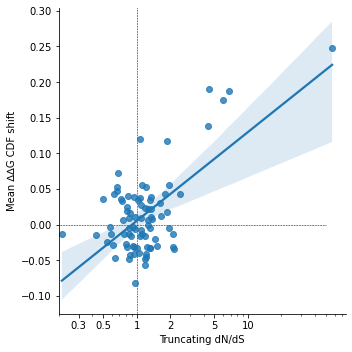

In [19]:
plt.figure(figsize=(5, 5))
sns.regplot(data=mer50, y='shift', x='wnon_cv', logx=True, truncate=True)
plt.xscale('log')

plt.xticks([0.3, 0.5, 1, 2, 5, 10], [0.3, 0.5, 1, 2, 5, 10])
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.plot([1, 1], [-5, 5], 'k--', linewidth=0.5, zorder=-1)
plt.plot([-10, 50], [0, 0], 'k--', linewidth=0.5, zorder=-1)
plt.xlim(xlim)
plt.xlim(left=0.2)
plt.ylim(ylim)
plt.ylabel('Mean ∆∆G CDF shift')
plt.xlabel('Truncating dN/dS')
hide_top_and_right_axes()
plt.tight_layout()
plt.savefig("truncating_dnds_vs_foldx_cdf_shift_mouse.pdf", transparent=True);

In [20]:
pearsonr(np.log(mer50['wnon_cv']), mer50['shift']) 

(0.6383636489762576, 6.477309385853157e-11)